In [9]:
from scipy.special import comb
import math
def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2.))
    probs = [comb(n_classifier,k)*
             error**k *
             (1-error)**(n_classifier-k)
             for k in range(k_start,n_classifier+1)]
    return sum(probs)
ensemble_error(n_classifier=11,error=0.25)

0.03432750701904297

<function matplotlib.pyplot.show(close=None, block=None)>

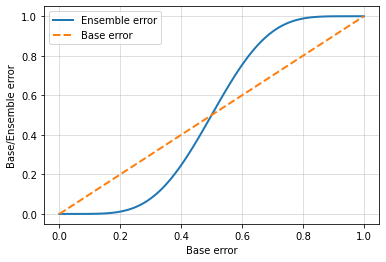

In [10]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error)
              for error in error_range]
plt.plot(error_range,ens_errors,
         label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,
         linestyle='--',label='Base error',linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show

In [16]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test =\
    train_test_split(X,y,
                     test_size=0.5,
                     random_state=1,
                     stratify=y)



In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2',
                          C=0.001,solver='lbfgs',
                          random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,
                          p=2,
                          metric='minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],
                  ['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],
                  ['clf',clf3]])

clf_labels=['Logistic regression','Decision tree','KNN']
print('10-fold cross_validation:\n')
for clf,label in zip([pipe1,clf2,clf3],clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          %(scores.mean(),scores.std(),label))

10-fold cross_validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.83 (+/- 0.15) [KNN]


In [19]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1,clf2,clf3]
)
clf_labels+=['Majority voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("AUC: %0.2f (+/- %0.2f) [%s]"
          %(scores.mean(),scores.std(),label))

AUC: 0.92 (+/- 0.15) [Logistic regression]
AUC: 0.87 (+/- 0.18) [Decision tree]
AUC: 0.85 (+/- 0.13) [KNN]
AUC: 0.95 (+/- 0.11) [Majority voting]


AttributeError: 'Line2D' object has no property 'linestyles'

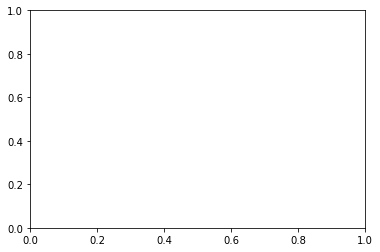

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf ,label,clr ,ls \
    in zip(all_clf,clf_labels,colors,linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,
                                   y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,
             color=colors,
             linestyles=linestyles,
             label='%s (auc= %0.2f)'%(label,roc_auc))